<a href="https://colab.research.google.com/github/SarraLKSC/Salamander_Individual_Identification/blob/main/Notebooks/Evaluation_of_Patch_Wise_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**


# 0. Import dependencies and load data

In [ ]:
import os
import re
import cv2
import math
import random
import sklearn
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.svm import SVC
from matplotlib import patches
from google.colab import drive
import matplotlib.pyplot as plt
from skimage.draw import ellipse
from sklearn.cluster import KMeans
from skimage.transform import rotate
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import mahalanobis
from sklearn.neighbors import KNeighborsClassifier
from skimage.measure import label, regionprops, regionprops_table

In [ ]:
#register_heif_opener()
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
images =["/content/drive/MyDrive/boleil_annotated/best_pattern_spot/"+ doc for doc in os.listdir("/content/drive/MyDrive/boleil_annotated/best_pattern_spot")]
img_root="/content/drive/MyDrive/boleil_annotated/best_pattern_spot"

In [ ]:
images.sort()

In [ ]:
len(images)

306

# 1. Functions


In [ ]:
BATCH=0
def load_batch(batch=0,size=50):
  """
    return a batch of data of given size as a dictionary for which the key is the path and the item is the loaded image
  """
  msk_samples={}
  start=50*batch
  end=len(images) #start+50

  for i in range(start,end):

    if i>len(images):
      return msk_samples

    msk_= np.asarray(Image.open(os.path.join(img_root,images[i])).convert('L'))
    msk_samples[images[i]]=msk_

    print("\r"+str(i)+"/"+str(len(images)),end="")

  return msk_samples

def map_path_id(keys):
  """
   returns a dictionary for which the key is the id and the item is the path
   this dictionary is later on used to easily leverage the dict of data
  """
  dict_keys={}

  for k in keys :
    id= "".join(filter(str.isdigit, k))
    id = int(id)
    if id in dict_keys.keys():
      dict_keys[id].append(k)
    else:
      dict_keys[id]=[k]

  return dict_keys

In [ ]:
def get_centroid(img):
  """
    return the centroid of the pattern foreground in binary image img
  """

  img = img.astype(np.uint8)  # Convert the image to uint8 data type
  contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnt =np.concatenate(contours)
  cnt = cnt.reshape(-1, 2)
  centroid = np.mean(cnt, axis=0)

  return centroid[0],centroid[1]


def get_patchs(image,patch_size=32,stride=0,centroid=False):
  """
    generate patchs from input image
    by default outputs 32x32 patchs without stride
    if centroid= True => we return the list of coordinates of each path with respect to the foreground centroid
  """
  patches=[]
  coords =[]
  cx,cy= get_centroid(image)

  image_height, image_width = image.shape
  if stride== 0:
    num_patches_vertical = image_height // patch_size
    num_patches_horizontal = image_width // patch_size

    for i in range(num_patches_vertical):
      for j in range(num_patches_horizontal):
        patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
        patches.append(patch)
        x= (i*patch_size) - cx + patch_size // 2
        y= (j*patch_size) - cy + patch_size // 2
        coords.append((x,y))

  else :
    num_patches_vertical = (image_height - patch_size) // stride + 1
    num_patches_horizontal = (image_width - patch_size) // stride + 1

    for i in range(num_patches_vertical):
      for j in range(num_patches_horizontal):
        patch = image[i * stride: i * stride + patch_size, j * stride: j * stride + patch_size]
        patches.append(patch)
        x= (i * stride) - cx + patch_size // 2
        y= (j * stride) - cy + patch_size // 2
        coords.append((x,y))

 # print(len(patches))
  if centroid:
    return patches,coords
  else:
    return patches

def moments_reduction(patch,pix=False,id=None):
  """
    generate the vector of central normalized moments for a patch
    returns a vector of shape (24,) with moment values or shape (25,) with moment values and assigned id label
  """
  moments=[]
  sum_p=np.sum(patch)

  contours,_= cv2.findContours(patch, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  if len(contours)>0:
    cnt=np.concatenate(contours)
  else: cnt=contours
  mmnt= cv2.moments(cnt)
  moments=list(mmnt.values())

  if pix:
    moments.extend(patch.flatten())
  if id is not None:
    moments.append(int(id))

  return moments

def vector_reduction(patch,id=None):
  """
    generate the vector of flattened patch
    returns a vector of shape (1024,) with pixel values or shape (1025,) with assigned id label
  """
  vectors=patch.flatten()
  if id is not None:
    vectors=np.append(vectors,int(id))
  return vectors

def centroid_reduction(patch,centroid,pixel=True,nu=False,id=None):
  """
    return a feature vector composed of (x,y) the position of the patch with respect ot the centroid of the pattern,
    followed by nu moments and/or pixels based on boolan parameters passed in the function, and the id.
  """

  vector=[]
  ## vector starts with localisation information x,y
  vector.append(centroid[0])
  vector.append(centroid[1])
  if nu:
    vector.extend(moments_reduction(patch))
  if pixel:
    vector.extend(patch.flatten())
  if id is not None:
    vector.append(int(id))

  return vector

def decode_features(feature_vect):
  pixel_vect=feature_vect[-1024:]
  img= np.reshape(pixel_vect, (32, 32))

  return img


def get_non_zero_patchs(image,patch_size=32,stride=0,centroid=False):
  """
  apply selection to the patchs generated by get_patchs function to filter out zero patches
  """

  if centroid:
   patches, coords = get_patchs(image, patch_size, stride, centroid)
   filter_patches = [np.sum(patch) != 0 for patch in patches]
   non_zero_patches = [patch for patch, flag in zip(patches, filter_patches) if flag]
   non_zero_coords = [coord for coord, flag in zip(coords, filter_patches) if flag]

   return non_zero_patches, non_zero_coords

  else:
    patches= get_patchs(image,patch_size,stride,centroid)
    filter_patches = [np.sum(patch)!=0 for patch in patches]
    non_zero_patches = [patch for patch,flag in zip(patches,filter_patches) if flag]

    return non_zero_patches

def non_zero_patchs_idx(image):
  idx=[]

  image= cv2.resize(image,(256,256))
  patchs=get_patchs(image,stride=32)####)

  for i,p in enumerate(patchs):

    somme= np.sum(p)
    if somme !=0:
      idx.append(i)
  return(np.asarray(idx))

In [ ]:
def get_data(reshaped=False,nu=True,images_too=False,skip_img=None):
  """
    returns dataset made of the loaded batch
    if nu = True returns the moments vector
    if reshapred = True returns reshaped dataset
    if images_too= True returns original data as well
    skip_img parameter is used during evaluation to set a query image aside from the training data.
  """
  ZEROES=False
  STRIDE=16
  SIZE=32
  dataset= []
  data= load_batch(BATCH)
  for name,img in data.items():
    if skip_img != None:
      if name == skip_img:
        continue
    img= cv2.resize(img,(256,256))
    id= "".join(filter(str.isdigit, name))
    id = int(id)

    if ZEROES:  #if we keep zero patches in data
      patchs= get_patchs(img,stride=STRIDE,patch_size=SIZE)
      if nu:
        nu_patches  =[moments_reduction(p,id) for p in patchs]
      #nu_patches  =[centroid_reduction(p,c,pixel=True,nu=True,id=id) for (p,c) in zip(patchs,coords)] ##vector of coords, nu moments, pixels
      else:
        nu_patches=[vector_reduction(p,id) for p in patchs]
      #nu_patches  =[centroid_reduction(p,c,pixel=True,id=id) for (p,c) in zip(patchs,coords)]  ##vector of coords, pixels

      dataset.append(np.array(nu_patches))

    else: #if we filter out zero patches from data

      patchs= get_patchs(img,stride=STRIDE,patch_size=SIZE)

      if nu:
        nu_patches  =[dataset.append(moments_reduction(p,pix=True,id=id)) for p in patchs if np.sum(p)!=0]
        #nu_patches  =[dataset.append(centroid_reduction(p,c,pixel=True,nu=True,id=id)) for (p,c) in zip(patchs,coords)] ##vector of coords, nu moments, pixels
      else:
        nu_patches=[dataset.append(vector_reduction(p,id)) for p in patchs if np.sum(p)!=0]
      #nu_patches  =[centroid_reduction(p,c,pixel=True,id=id) for (p,c) in zip(patchs,coords)]  ##vector of coords, pixels

  if reshaped:
    return reshape_data(np.array(dataset))
  if images_too:
    return np.array(dataset),data
  else:
    return np.array(dataset)


def reshape_data(dataset,nu=True):
  """
    reshapes the dataset so that the patches are presented together
    i.e first row is all the first top left corner of all samples and last row is all the bottom right corner of all samples

  """

  # 1) Transpose the dataset to have the rows as the first dimension
  # 2) Reshape the transposed dataset to get 64 datasets of shape (50, 8)
  print(dataset.shape)
  if len(dataset.shape)==3:
    _,nb_patchs,nb_dims= dataset.shape

    if nu:
      transposed_dataset = np.transpose(dataset, (1, 0, 2))
      separated_datasets = np.reshape(transposed_dataset, (nb_patchs, 150, 1048)) ##### 64 now 255
    else:
      transposed_dataset = np.transpose(dataset, (1, 0, 2))
      separated_datasets = np.reshape(transposed_dataset, (nb_patchs, 150, 1025)) ##### 64 now 255

      return separated_datasets
  return dataset


def plot_blocks(img,patch_size=32,stride=0):
  """
    plot the image with red vertical and horizontal lines that allow to vizualize the patch separation
    in the case of a stride a blue rectangle to shows the size of patch
  """

  img=cv2.resize(img,(256,256))
  fig, ax = plt.subplots()

  ax.imshow(img, cmap='gray')

  grid_color = 'red'
  grid_linewidth = 0.5
  patch_color = 'blue'
  patch_linewidth = 3

  if stride ==0:
    for i in range(8):
      ax.axvline(i*32, color=grid_color, linewidth=grid_linewidth)

    for i in range(8):
      ax.axhline(i*32, color=grid_color, linewidth=grid_linewidth)

  else:
    num_patches_vertical = img.shape[0] // stride
    num_patches_horizontal = img.shape[1] // stride

    for i in range(num_patches_vertical):
        ax.axhline(i * stride, color=grid_color, linewidth=grid_linewidth)

    for i in range(num_patches_horizontal):
        ax.axvline(i * stride, color=grid_color, linewidth=grid_linewidth)
    rect = patches.Rectangle((0, 0), patch_size, patch_size, linewidth=patch_linewidth,
                             edgecolor=patch_color, facecolor='none')
    ax.add_patch(rect)

  ax.set_aspect('equal')
  plt.show()

In [ ]:
LABELS=[]
def patch_solo_knns(dataset,samples_too=False):
  """
  build and train knn classifier on dataset
  samples_too : boolean value dictating if we return labels of the knn samples
  returns a trained knn classifier
  """

  if len(dataset.shape)==3:
    nb_patchs,nb_samples,nb_dims= dataset.shape

    trainset= np.reshape(dataset,(nb_patchs*nb_samples,nb_dims))
  else :
    nb_patchs,nb_dims= dataset.shape
    trainset=dataset

  np.random.shuffle(trainset)
  train_samples,train_labels= trainset[:,:24] , trainset[:,-1]
  test_samples,test_labels  = trainset[-100:,:24] , trainset[-100:,-1]

  train_samples = train_samples.astype(np.float32)
  train_labels = train_labels.astype(np.float32)

  test_samples = test_samples.astype(np.float32)
  test_labels = test_labels.astype(np.float32)

  LABELS=train_labels
  SAMPLES=trainset[:,:-1] #train_samples

  print("len(train)={}. ; len(test)={}".format(len(train_samples),len(test_samples)))

   # Compute the covariance matrix for Mahalanobis distance
  epsilon = 1e-6  # Small positive constant for regularization
  cov_matrix = np.cov(train_samples, rowvar=False)
  inv_cov_matrix = np.linalg.inv(cov_matrix + epsilon * np.eye(cov_matrix.shape[0]))

  def mahalanobis_distance(x, y):
    return mahalanobis(x, y, inv_cov_matrix)

  knn = KNeighborsClassifier(n_neighbors=5, metric=mahalanobis_distance)
  knn.fit(train_samples, train_labels)

  dist,neighbors = knn.kneighbors(test_samples,n_neighbors=5)
  result = knn.predict(test_samples)

  matches = result==test_labels

  correct = np.count_nonzero(matches)
  accuracy = correct*100.0/result.size
  print( "accuracy : {}".format(accuracy) )
  if samples_too:
    return knn,LABELS,SAMPLES
  return knn,LABELS


def get_solo_knn_votes(image,solo_knn,nu=True):
  """
    gets the votes assigned for each patch of image based on the solo_knn classifier.
    image: the image to predict on, it is split in patches and transformed in feature vector before infering the KNN
  """
  STRIDE=16
  SIZE=32
  patch_votes=[]
  patch_indices=[]
  patch_dist=[]
  # resize image to 256,256
  image=cv2.resize(image,(256,256))
  # get patchs of the image
  patchs=get_patchs(image,stride=16,patch_size=SIZE) #####)
  non_zero_idx=non_zero_patchs_idx(image)

  # get nu moments vectors
  if nu:
    nu_patches  =[moments_reduction(p,pix=False) for i,p in enumerate(patchs) if i in non_zero_idx]
   # nu_patches  =[centroid_reduction(p,c,pixel=True,nu=True,id=id) for i,(p,c) in zip(patchs,coords)] ##vector of coords, nu moments, pixels

  else :
    nu_patches  =[vector_reduction(p) for i,p in enumerate(patchs) if i in non_zero_idx]
  nu_patches  =np.asarray(nu_patches)

  # get knn vote for each patch

  for i,patche in enumerate(nu_patches):
    print("\rsolo KNN vote "+str(i)+"/"+str(len(nu_patches)),end="")
    # run prediction for patch i
    patche =patche.astype(np.float32)  # Convert to CV_32F

    tmp=np.asarray( [patche])
    tmp=tmp.astype(np.float32)

    result = solo_knn.predict(tmp)
    distances, indices = solo_knn.kneighbors(tmp, n_neighbors=5)

    # append the prediction of patch i to the patch votes
    patch_votes.append(result.flatten())
    patch_indices.append(indices.flatten())
    patch_dist.append(distances.flatten())

  #print("\nshape of input patch feature vector {}".format(tmp.shape))
  return patch_votes,patch_indices,patch_dist


def solo_knn_results(image,dataset,displayed=True,return_df=False):
  """
    display intermediate results such as the KNN predictions for each patch and the selected non-zero patchs result and frequence of the selected votes
  """
  if len(dataset.shape)==3:
    nb_patchs,_,dims= dataset.shape
  else :
    nb_patchs = 225
    dims=dataset.shape[1]

  nu=True
  if dims==1025:
    nu=False

  patch_KNN,LABELS,SAMPLES= patch_solo_knns(dataset,samples_too=True)

  patch_votes,patch_indices,patch_dist= get_solo_knn_votes(image,patch_KNN,nu)
  df=pd.DataFrame(np.asarray(patch_votes).reshape(len(patch_votes),),columns=["votes"])
  df["indices"]=patch_indices
  df['neighbours'] = df['indices'].apply(lambda x: [LABELS[i] for i in x])
  df["dist"]=patch_dist
  df['votes'] = df['neighbours'].apply(lambda x: x[0])

  pd.set_option("display.max_rows", None)

  non_zero_idx=non_zero_patchs_idx(image)
  extracted_values = df['votes'] #df.iloc[non_zero_idx]['votes']
  selected_rows = df #df.loc[non_zero_idx]

  if displayed:
    display(selected_rows)

  exploded_df = df.explode("indices")

  # Get the distinct values from the exploded "neighbours" column
  distinct_values = exploded_df["indices"].unique()

  value_counts = extracted_values.value_counts()
  frequency_df = pd.DataFrame({'votes': value_counts.index, 'frequency': value_counts.values})

  if displayed:
    display(frequency_df)
  if return_df:
    return frequency_df,SAMPLES


In [ ]:
def patch_solo_svm(dataset, samples_too=False):

    if len(dataset.shape) == 3:
        nb_patchs, nb_samples, nb_dims = dataset.shape
        trainset = np.reshape(dataset, (nb_patchs * nb_samples, nb_dims))
    else:
        nb_patchs, nb_dims = dataset.shape
        trainset = dataset

    print(nb_dims)
    train_samples, train_labels = trainset[:, :24], trainset[:, -1]
    test_samples, test_labels = trainset[-100:, :24], trainset[-100:, -1]

    train_samples = train_samples.astype(np.float32)
    train_labels = train_labels.astype(np.float32)

    test_samples = test_samples.astype(np.float32)
    test_labels = test_labels.astype(np.float32)

    LABELS = train_labels

    # Create and fit SVM model
    svm = SVC(kernel='rbf', C=10,decision_function_shape="ovo", class_weight='balanced')  # You can choose different kernel and parameters
    svm.fit(train_samples, train_labels)

    # Predict on test set
    result = svm.predict(test_samples)

    if samples_too:
        return svm, LABELS, trainset[:, :-1]
    return svm, LABELS


def get_solo_svm_votes(image,solo_svm,nu=True):

  STRIDE=16
  patch_votes=[]
  SIZE=256
  # resize image to 256,256
  image=cv2.resize(image,(SIZE,SIZE))
  # get patchs of the image
  patchs=get_patchs(image,stride=STRIDE) #####)
  non_zero_idx=non_zero_patchs_idx(image)
  #patchs= get_non_zero_patchs(img,stride=STRIDE)


  # get nu moments vectors
  if nu:
    nu_patches  =[moments_reduction(p,pix=False) for i,p in enumerate(patchs) if i in non_zero_idx]
   # nu_patches  =[centroid_reduction(p,c,pixel=True,nu=True,id=id) for i,(p,c) in zip(patchs,coords)] ##vector of coords, nu moments, pixels

  else :
    nu_patches  =[vector_reduction(p) for i,p in enumerate(patchs) if i in non_zero_idx]
  nu_patches  =np.asarray(nu_patches)
  #print("nu patches {} ; element of it {}".format(nu_patches.shape,nu_patches[0].shape))
  # get knn vote for each patch
  #print(solo_knn.classes_)
  for i,patche in enumerate(nu_patches):
    print("\rsolo KNN vote "+str(i)+"/"+str(len(nu_patches)),end="")
    # run prediction for patch i on knn that was trained on patchs of position i
    patche =patche.astype(np.float32)  # Convert to CV_32F

    tmp=np.asarray( [patche])
    tmp=tmp.astype(np.float32)

    result = solo_svm.predict(tmp)

    # Get the labels of the neighboring samples
   # neighbor_labels = solo_knn.classes_[indices]

    # append the prediction of patch i to the patch votes
    patch_votes.append(result.flatten())

  print("\nshape of input patch feature vector {}".format(tmp.shape))
  return patch_votes

def solo_svm_results(image,dataset,displayed=True,return_df=False):
  """
    display intermediate results such as the svm predictions for each patch and the selected non-zero patchs result and frequence of the selected votes
  """
  if len(dataset.shape)==3:
    nb_patchs,_,dims= dataset.shape
  else :
    nb_patchs = 225
    dims=dataset.shape[1]

  nu=True
  if dims==1025:
    nu=False
  #print("gonna go patch solo knns")
  patch_svm,LABELS,SAMPLES= patch_solo_svm(dataset,samples_too=True)
  #print("gonna go get solo knns votes")
  patch_votes= get_solo_svm_votes(image,patch_svm,nu)

  df=pd.DataFrame(np.asarray(patch_votes).reshape(len(patch_votes),),columns=["votes"])

  df['votes'] = patch_votes #df['neighbours'].apply(lambda x: x[0])

  pd.set_option("display.max_rows", None)

  non_zero_idx=non_zero_patchs_idx(image)
  extracted_values = df.iloc[non_zero_idx]['votes']
  selected_rows =df.loc[non_zero_idx]

  if displayed:
    display(selected_rows)


  # Get the distinct values from the exploded "neighbours" column

  # Print the distinct values
  #print(distinct_values)
  if len(LABELS)==0:
    print("LABELS was not assigned inside the knn vote function ")
  else:
    print(LABELS)
  value_counts = extracted_values.value_counts()
  frequency_df = pd.DataFrame({'votes': value_counts.index, 'frequency': value_counts.values})

  if displayed:
    display(frequency_df)
  if return_df:
    return frequency_df,SAMPLES


In [ ]:


def display_solo_votes(image,dataset,images):
  """
      display for each non-zero patch of the image to predict, the corresponding patch of the predicted identity
  """
  if len(dataset.shape)==3:
    nb_patchs,_,dims= dataset.shape
  else :
    nb_patchs = 225
    dims=dataset.shape[1]

  nu=True
  if dims==1025:
    nu=False
  #train KNNs
  patch_KNN,LABELS,SAMPLES= patch_solo_knns(dataset,samples_too=True)

  print("SAMPLES shape = {}; SAMPLES[4332] shape = {};".format(SAMPLES.shape,SAMPLES[4332].shape))
  #run KNNs on image
  patch_votes,patch_indices,patch_dist= get_solo_knn_votes(image,patch_KNN,nu)

  #get image patches
  image= cv2.resize(image,(256,256))
  patchs=get_patchs(image,stride=16)########)
  #get non-zero patches and their votes
  non_zero_idx=non_zero_patchs_idx(image)
  #build df of results
  df=pd.DataFrame(np.asarray(patch_votes).reshape(len(patch_votes),),columns=["votes"],index=non_zero_idx)
  df["indices"]=patch_indices
  df['neighbours'] = df['indices'].apply(lambda x: [LABELS[i] for i in x])
  df["dist"]=patch_dist

  extracted_values = df['votes'] #df.iloc[non_zero_idx]['votes']
  extracted_neighbors =df['neighbours'] # df.iloc[non_zero_idx]['neighbours']
  extracted_indices = df['indices']#df.iloc[non_zero_idx]['indices']

  for idx in non_zero_idx:
    fig=plt.figure(figsize=(13,13))
    predicted_id= extracted_values[idx]
    neighbors=extracted_neighbors[idx]
    indices = extracted_indices[idx]

    print("neighbors: {} ; indices: {}".format(neighbors,indices))
    #print("len neighbors : {} ; len indices : {}".format(len(neighbors),len(indices)))

    plt.subplot(1,6,1)
    plt.imshow(patchs[idx],cmap="gray")
    plt.title(" patch {} voted id ={}".format(idx,predicted_id))
    plt.axis("off")
    for i in range (2,7):

      plt.subplot(1,6,i)
      indice= indices[i-2]
      sample= SAMPLES[int(indice)]
      #print("for the point {} : indices : {} of type {}; sample has shape {}".format((i-2),indice,type(indice),sample.shape))

      img = decode_features(sample)
      plt.imshow(img,cmap="gray")
      plt.title("label {}".format(LABELS[indice]))
      plt.axis("off")

    plt.show()


# 2. Running code

In [ ]:
data,dataset_dict=get_data(nu=True,images_too=True)
print("\nshape of dataset : {} ; shape of each sample : {}".format(data.shape,data[0].shape))
reshaped_data=reshape_data(data,nu=True)
print("\nshape of dataset : {} ; shape of each patch dataset : {}".format(reshaped_data.shape,reshaped_data[0].shape))

305/306
shape of dataset : (18235, 1049) ; shape of each sample : (1049,)
(18235, 1049)

shape of dataset : (18235, 1049) ; shape of each patch dataset : (1049,)


In [ ]:
v_,SAMPLES=solo_svm_results(list(dataset_dict.values())[18],reshaped_data,return_df=True)

1049
solo KNN vote 66/67
shape of input patch feature vector (1, 24)


,votes
0,[9.0]
1,[244.0]
2,[50.0]
3,[50.0]
4,[50.0]
5,[9.0]
6,[9.0]
7,[242.0]
8,[50.0]
9,[50.0]


[  1.   1.   1. ... 323. 323. 323.]


,votes,frequency
0,[50.0],47
1,[9.0],5
2,[182.0],4
3,[244.0],2
4,[242.0],1
5,[226.0],1
6,[16.0],1
7,[198.0],1
8,[321.0],1
9,[285.0],1


In [ ]:
v_,SAMPLES=solo_knn_results(list(dataset_dict.values())[18],reshaped_data,return_df=True)

len(train)=90900. ; len(test)=100
accuracy : 5.0
solo KNN vote 66/67
shape of input patch feature vector (1, 24)


,votes,indices,neighbours,dist
0,[9.0],"[12257, 21065, 32523, 5792, 36777]","[12.0, 9.0, 244.0, 52.0, 145.0]","[0.0, 1.488568397183742, 1.74657434042559, 1.7..."
1,[12.0],"[88663, 74685, 51419, 49230, 22289]","[12.0, 35.0, 306.0, 54.0, 102.0]","[0.0, 4.002937312308725, 4.371080939166061, 4...."
2,[12.0],"[76534, 86461, 11910, 21152, 89121]","[12.0, 75.0, 74.0, 319.0, 261.0]","[0.0, 1.5054350208119414, 1.9275796846226978, ..."
3,[12.0],"[77580, 77174, 39545, 13225, 4137]","[12.0, 188.0, 322.0, 121.0, 278.0]","[0.0, 0.09472962595399098, 0.1221380134204188,..."
4,[25.0],"[56210, 56213, 56209, 56207, 56211]","[32.0, 292.0, 25.0, 251.0, 98.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
5,[12.0],"[28156, 20117, 24812, 22461, 39710]","[12.0, 263.0, 172.0, 130.0, 230.0]","[0.0, 3.3857613136711264, 3.7379615300998923, ..."
6,[8.0],"[82709, 16838, 64583, 68186, 89366]","[12.0, 8.0, 262.0, 273.0, 171.0]","[0.0, 4.577577671563274, 4.6195716582493, 4.94..."
7,[12.0],"[36523, 18936, 7514, 83888, 30452]","[12.0, 171.0, 261.0, 248.0, 75.0]","[0.0, 1.9651547982222684, 2.6228625960058287, ..."
8,[12.0],"[21293, 51194, 86084, 7626, 15448]","[12.0, 114.0, 244.0, 197.0, 297.0]","[0.0, 0.4265735129516229, 0.6767347765978617, ..."
9,[12.0],"[18776, 75603, 37199, 59764, 6258]","[12.0, 224.0, 60.0, 107.0, 115.0]","[0.0, 1.4617731184049432, 1.6822295114505394, ..."


,votes,frequency
0,[12.0],55
1,[8.0],3
2,[7.0],2
3,[9.0],1
4,[25.0],1
5,[2.0],1
6,[11.0],1
7,[4.0],1
8,[112.0],1
9,[3.0],1


len(train)=90900. ; len(test)=100
accuracy : 7.0
SAMPLES shape = (90900, 1048); SAMPLES[4332] shape = (1048,);
solo KNN vote 59/60
shape of input patch feature vector (1, 24)
neighbors: [5.0, 230.0, 242.0, 318.0, 70.0] ; indices: [40638 60233 31462  5966 43649]


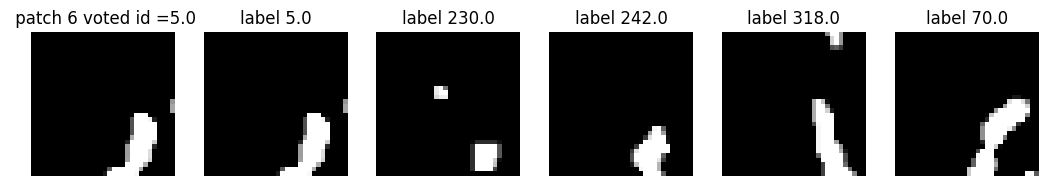

neighbors: [5.0, 192.0, 32.0, 188.0, 34.0] ; indices: [ 1244 16406 25502  1818 71305]


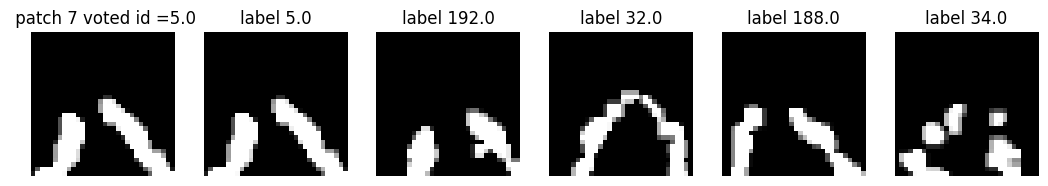

neighbors: [5.0, 174.0, 65.0, 256.0, 282.0] ; indices: [39090 38060 80000 43730 26344]


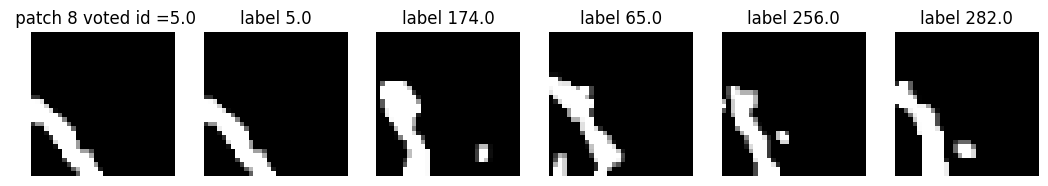

neighbors: [5.0, 218.0, 39.0, 93.0, 26.0] ; indices: [ 9524 65975 33521 73263 59543]


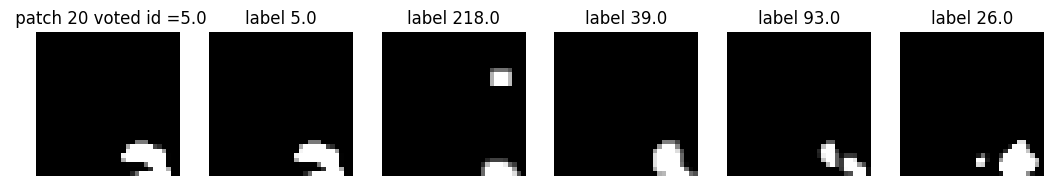

neighbors: [5.0, 165.0, 74.0, 296.0, 147.0] ; indices: [57778 25000 27734 22749 18055]


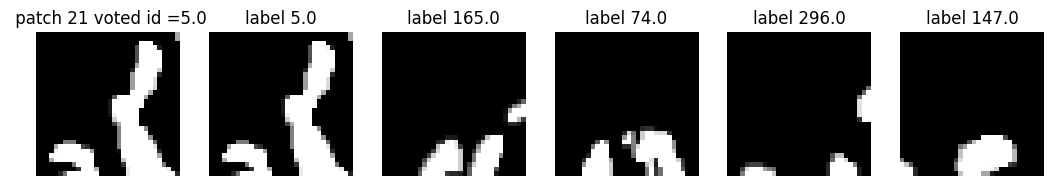

neighbors: [5.0, 222.0, 83.0, 74.0, 160.0] ; indices: [52380  1248 35846 52779  8737]


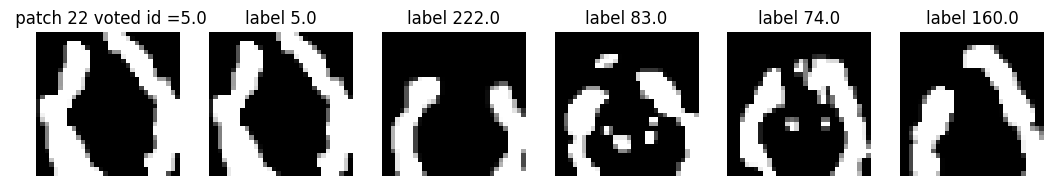

neighbors: [5.0, 77.0, 8.0, 59.0, 302.0] ; indices: [79092 13188 33177 32716 13034]


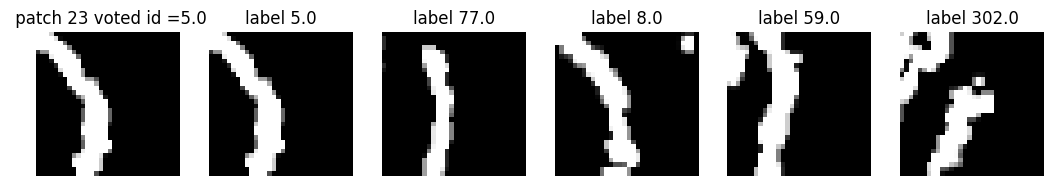

neighbors: [169.0, 20.0, 196.0, 315.0, 182.0] ; indices: [56196 56198 56195 56193 56197]


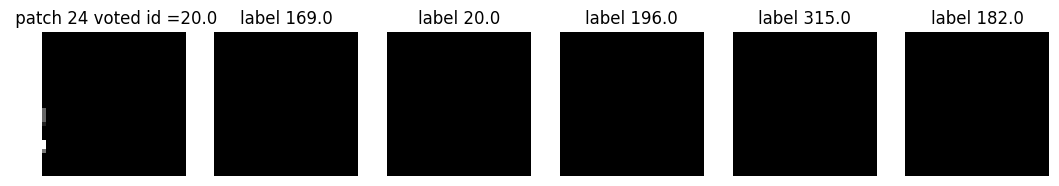

neighbors: [5.0, 61.0, 308.0, 8.0, 70.0] ; indices: [89474 37710 72989 88215 73332]


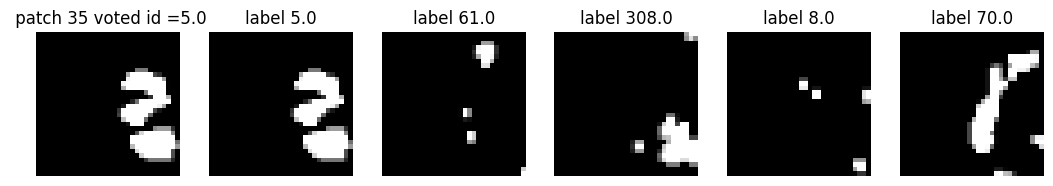

neighbors: [5.0, 70.0, 296.0, 59.0, 41.0] ; indices: [16298 78380 78525 64533 59732]


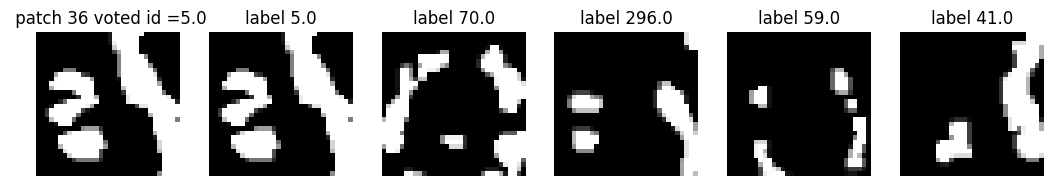

neighbors: [5.0, 32.0, 279.0, 96.0, 145.0] ; indices: [42894 19392 40089 80944 81129]


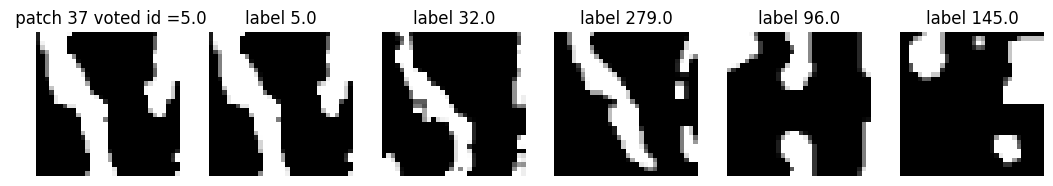

neighbors: [5.0, 162.0, 113.0, 85.0, 280.0] ; indices: [ 4974 29320 22859 66300 19834]


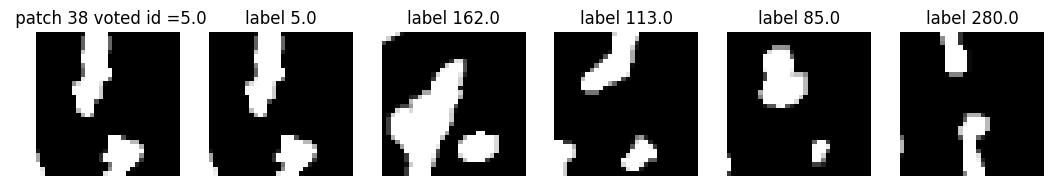

neighbors: [5.0, 181.0, 106.0, 1.0, 6.0] ; indices: [31814 54119 82627 51468 18257]


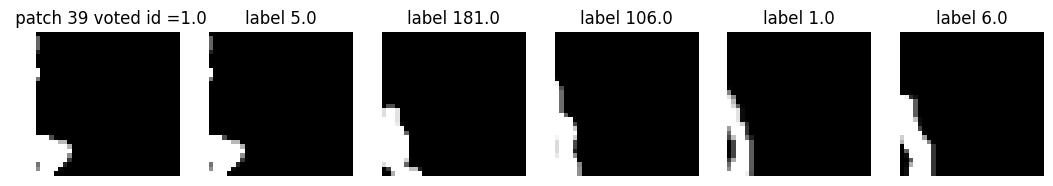

neighbors: [5.0, 222.0, 76.0, 320.0, 203.0] ; indices: [43168 81517 63833 65532 80665]


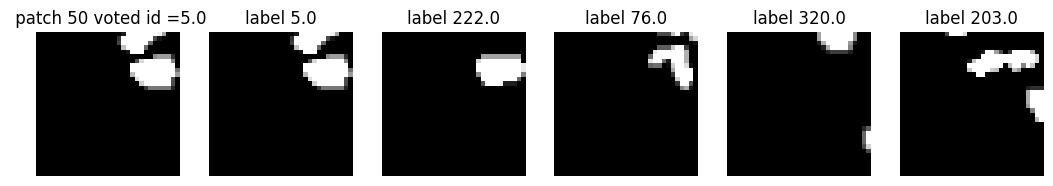

neighbors: [5.0, 160.0, 100.0, 182.0, 259.0] ; indices: [13739 66987 86889 38857 29458]


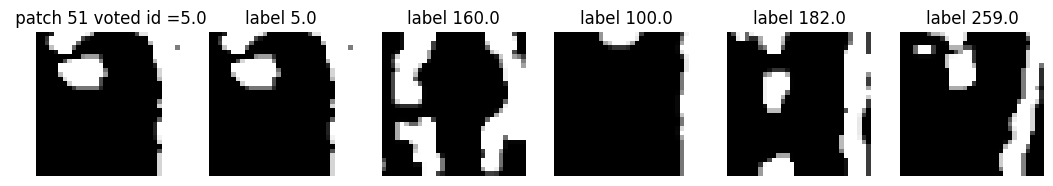

neighbors: [5.0, 8.0, 118.0, 107.0, 283.0] ; indices: [30468 77459 38046 38577 22468]


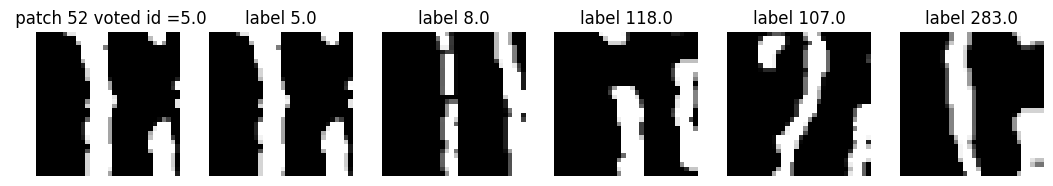

neighbors: [5.0, 199.0, 229.0, 119.0, 292.0] ; indices: [25935 38574 43506 32339 65655]


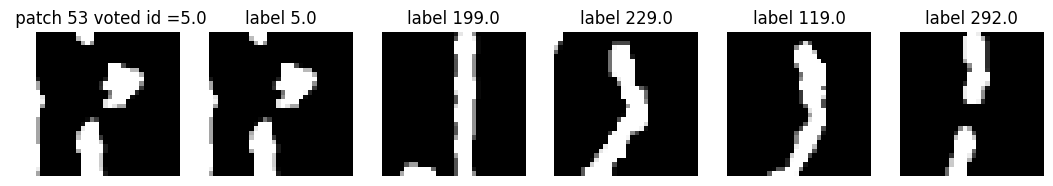

neighbors: [5.0, 216.0, 190.0, 136.0, 79.0] ; indices: [51465 89984 44467 67118 54956]


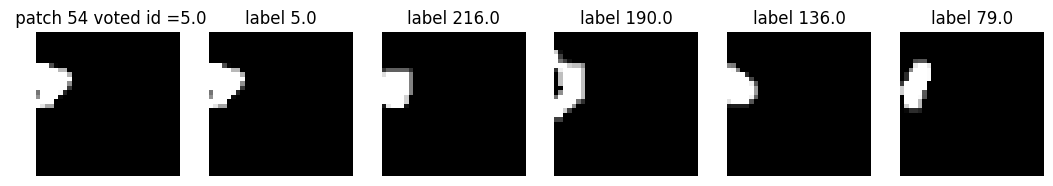

neighbors: [5.0, 262.0, 283.0, 14.0, 9.0] ; indices: [78141 48848 35032 21352 55889]


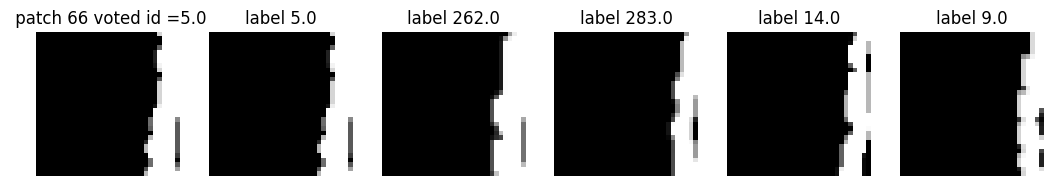

neighbors: [5.0, 69.0, 111.0, 100.0, 254.0] ; indices: [58539 37681  8805 77947 90797]


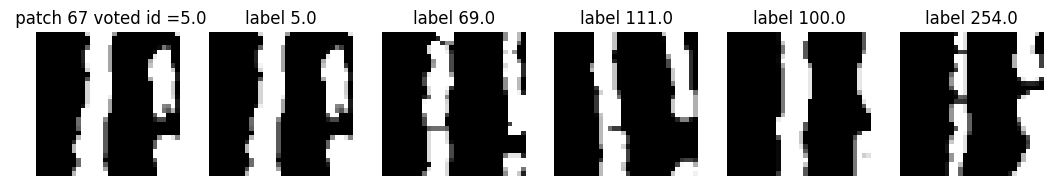

neighbors: [5.0, 55.0, 62.0, 70.0, 227.0] ; indices: [17798 56944 88777  6174 45034]


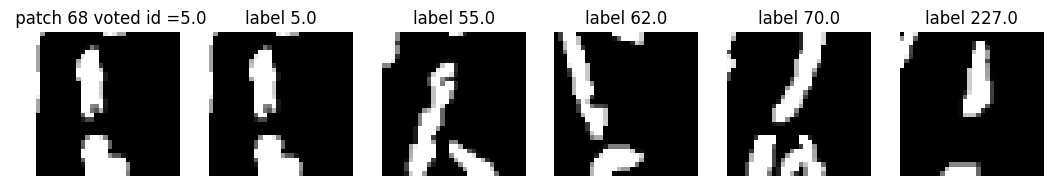

neighbors: [5.0, 2.0, 276.0, 57.0, 6.0] ; indices: [85903 44834 82821 83241 89731]


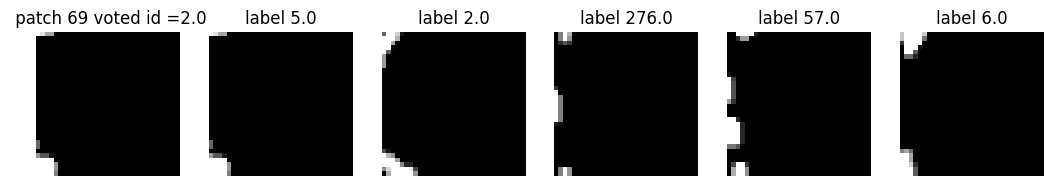

neighbors: [5.0, 4.0, 49.0, 69.0, 142.0] ; indices: [50104  6882 69075  4051  6164]


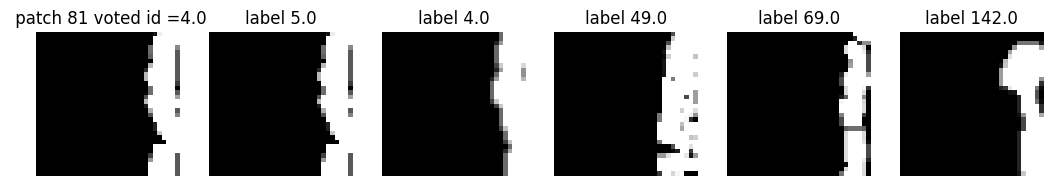

neighbors: [5.0, 37.0, 78.0, 140.0, 215.0] ; indices: [80698 41862 82555  6694 13602]


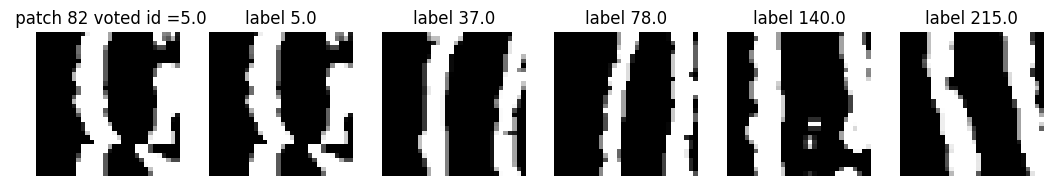

neighbors: [5.0, 186.0, 85.0, 87.0, 263.0] ; indices: [46679 87642 13161 84886 25310]


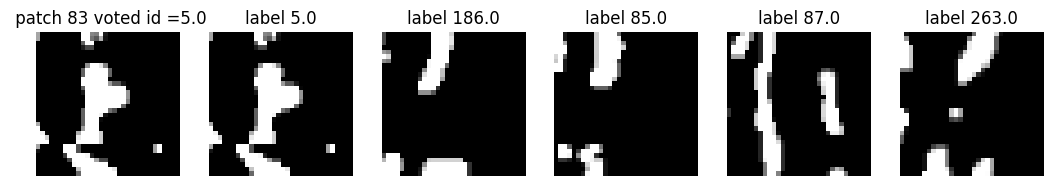

neighbors: [5.0, 163.0, 314.0, 18.0, 137.0] ; indices: [48795 29793 31008 59185 55872]


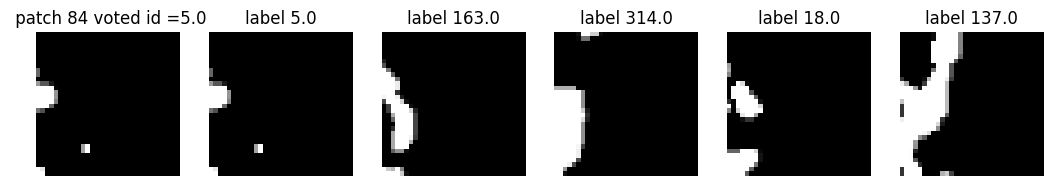

neighbors: [5.0, 9.0, 3.0, 228.0, 4.0] ; indices: [89107 87520 82072 20586  6882]


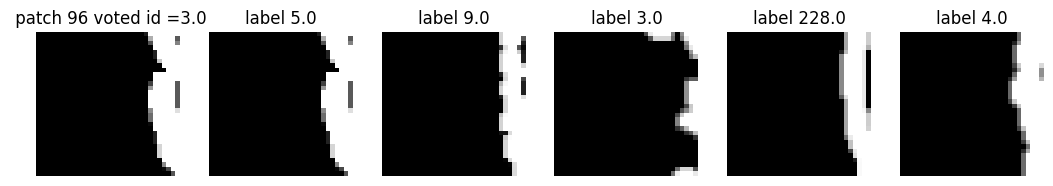

neighbors: [5.0, 119.0, 110.0, 156.0, 102.0] ; indices: [11779 77251 73360 70524 49323]


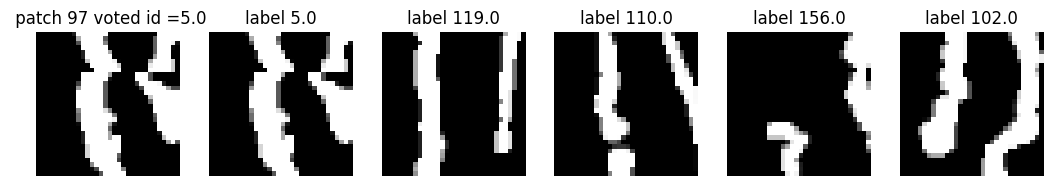

neighbors: [5.0, 190.0, 209.0, 150.0, 321.0] ; indices: [73716 40961 57230 17839 20105]


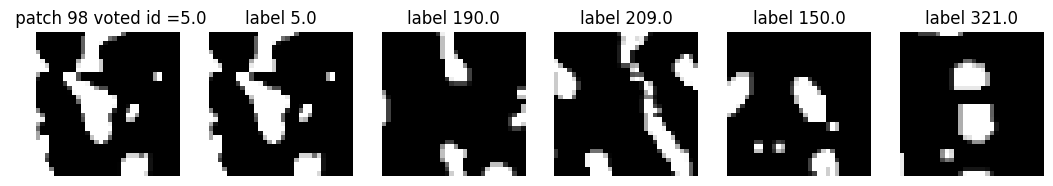

neighbors: [5.0, 179.0, 54.0, 54.0, 59.0] ; indices: [80149 12026 28401 24453 86154]


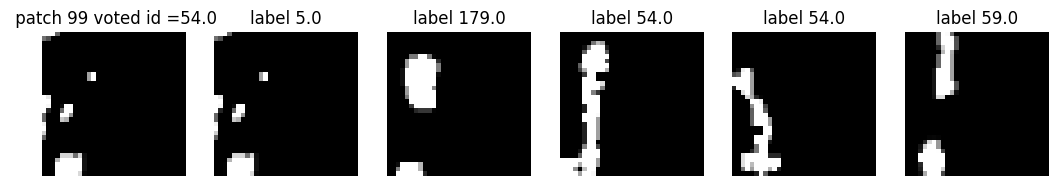

neighbors: [5.0, 261.0, 17.0, 132.0, 245.0] ; indices: [31025 83962 74540 10672 66579]


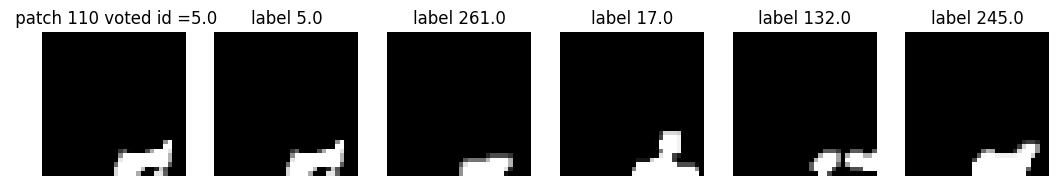

neighbors: [5.0, 97.0, 319.0, 267.0, 84.0] ; indices: [40133 55211 42571 15365 50539]


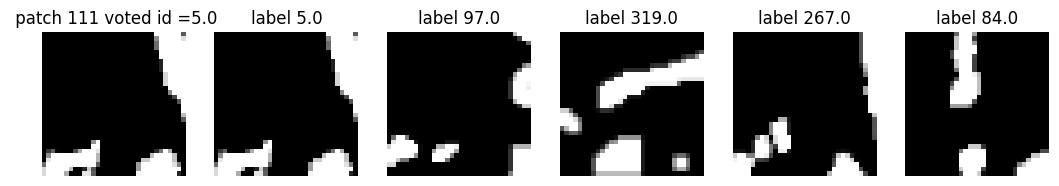

neighbors: [5.0, 121.0, 2.0, 150.0, 105.0] ; indices: [63513 69706 53350 57195 70900]


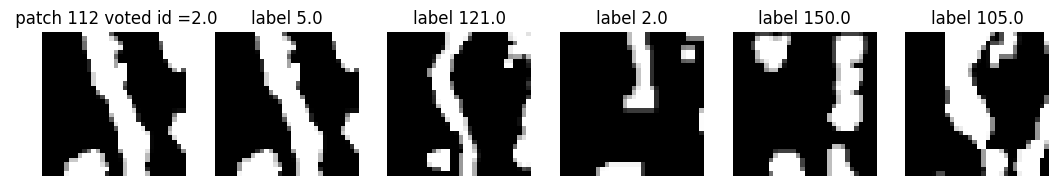

neighbors: [5.0, 68.0, 117.0, 21.0, 55.0] ; indices: [12227 29749 85761 78538 58109]


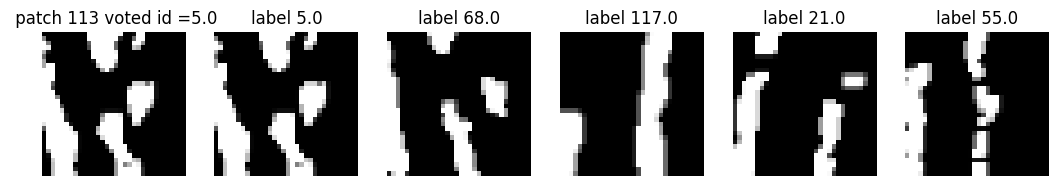

neighbors: [5.0, 70.0, 143.0, 316.0, 172.0] ; indices: [50633 68363  9882 24883 68800]


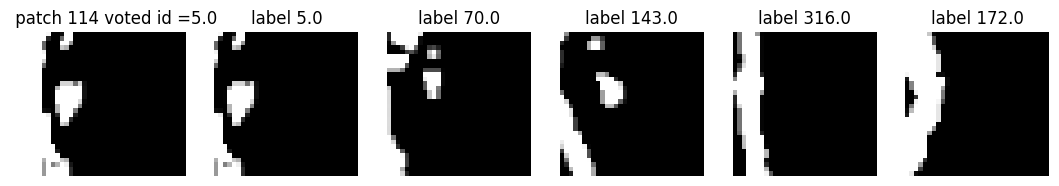

neighbors: [5.0, 82.0, 21.0, 19.0, 288.0] ; indices: [72010 37851 19752 82470 74477]


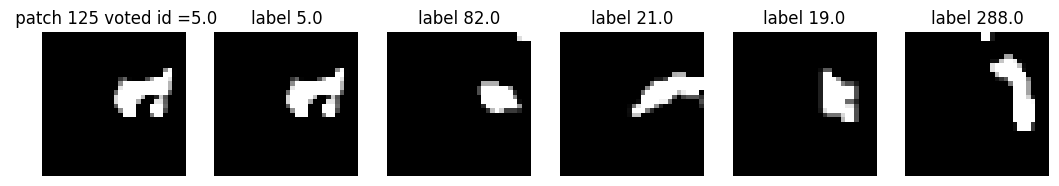

neighbors: [5.0, 267.0, 220.0, 4.0, 99.0] ; indices: [47292 52996  3351 15172 52354]


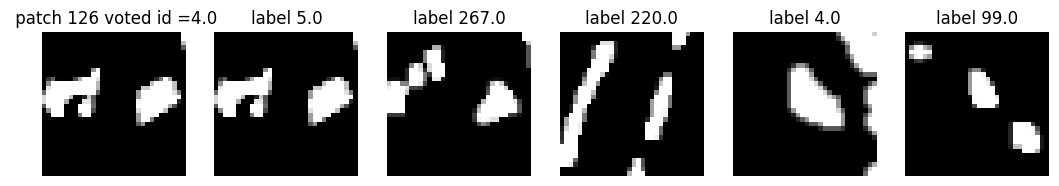

neighbors: [5.0, 28.0, 172.0, 291.0, 88.0] ; indices: [47631 78429   958 51703 32875]


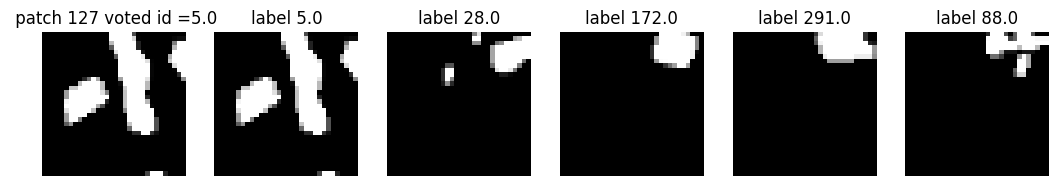

neighbors: [5.0, 141.0, 266.0, 277.0, 256.0] ; indices: [20148  7120 43326 22094 41721]


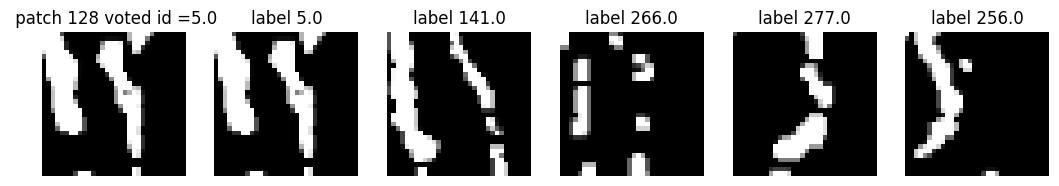

neighbors: [5.0, 159.0, 102.0, 162.0, 239.0] ; indices: [68778 52776 40767 38657 64423]


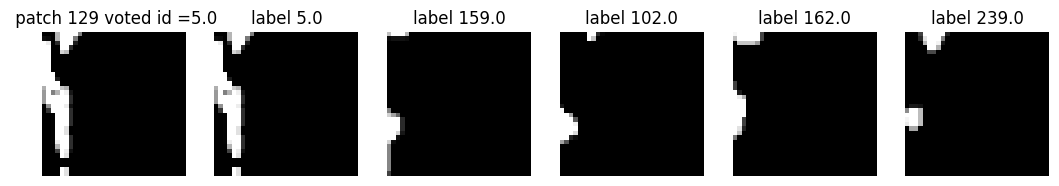

neighbors: [5.0, 107.0, 17.0, 39.0, 22.0] ; indices: [24337 78308 52151 82894 14778]


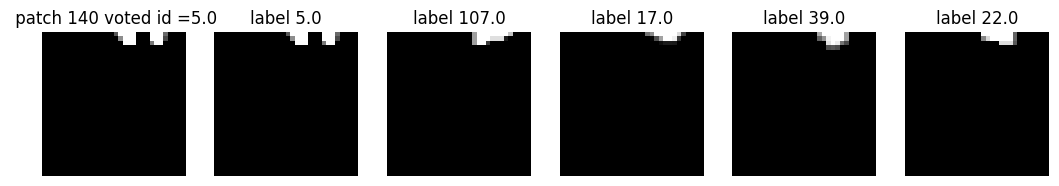

neighbors: [5.0, 319.0, 29.0, 69.0, 267.0] ; indices: [48268 89251  7124 10857  9644]


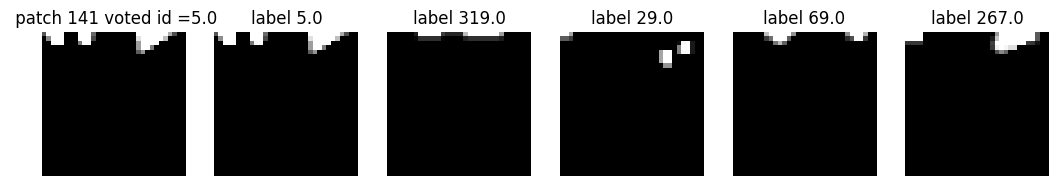

neighbors: [5.0, 10.0, 304.0, 267.0, 153.0] ; indices: [26462 63926 79828 34919 43759]


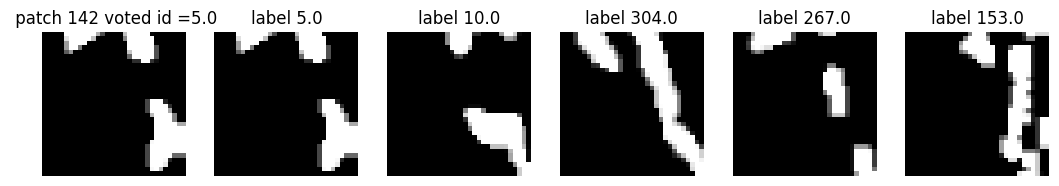

neighbors: [5.0, 228.0, 308.0, 109.0, 155.0] ; indices: [58620 56114 10232 38161 33206]


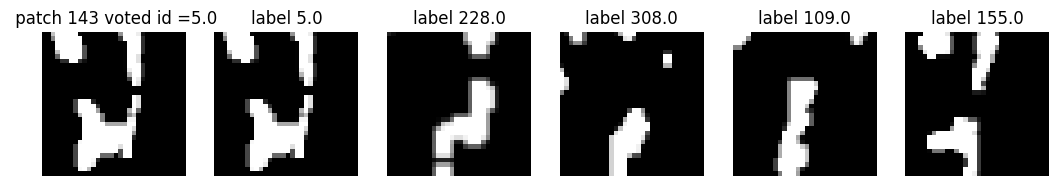

neighbors: [5.0, 23.0, 96.0, 200.0, 3.0] ; indices: [ 1915 51908 72036 65652 39389]


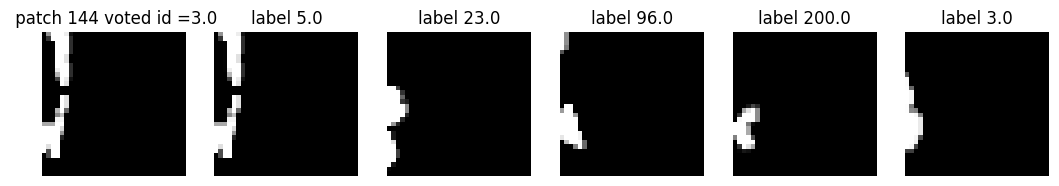

neighbors: [5.0, 214.0, 138.0, 19.0, 303.0] ; indices: [30488 40793 29780 71365 29183]


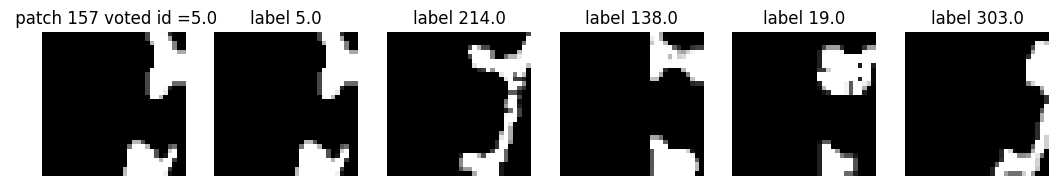

neighbors: [5.0, 219.0, 303.0, 111.0, 214.0] ; indices: [85400 18224 24460 83245 14042]


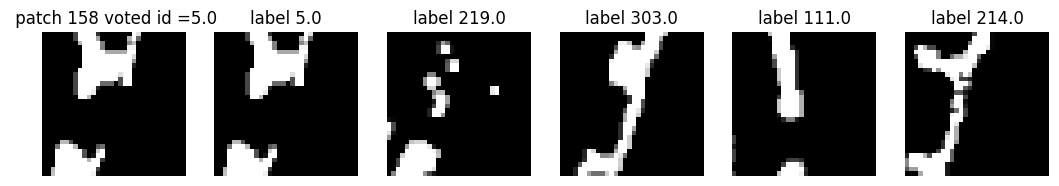

neighbors: [5.0, 291.0, 199.0, 176.0, 227.0] ; indices: [26493 40039 25465 17635 52197]


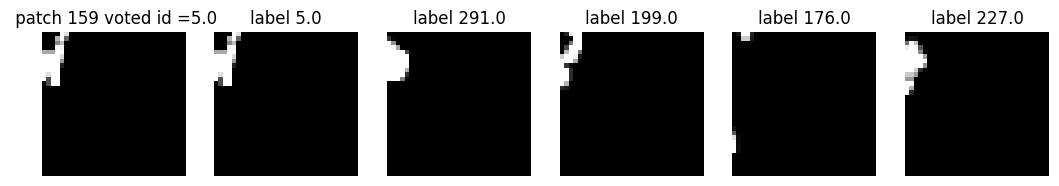

neighbors: [5.0, 68.0, 199.0, 124.0, 202.0] ; indices: [74018 59261 85355 43518 25175]


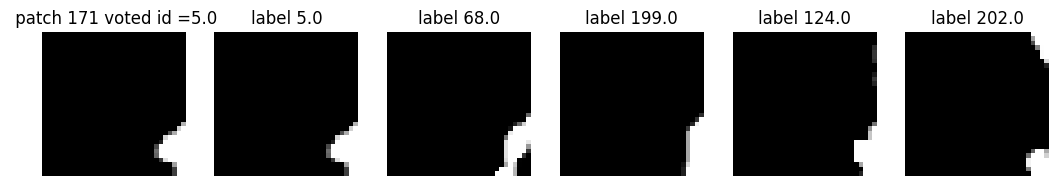

neighbors: [5.0, 263.0, 241.0, 229.0, 298.0] ; indices: [60429 23453 77190  7072 58220]


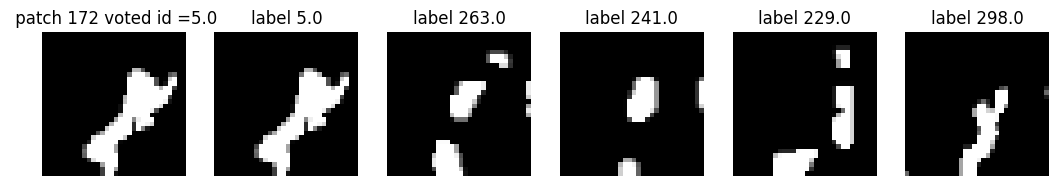

neighbors: [5.0, 112.0, 83.0, 44.0, 11.0] ; indices: [17725 61523 62860 11437 84410]


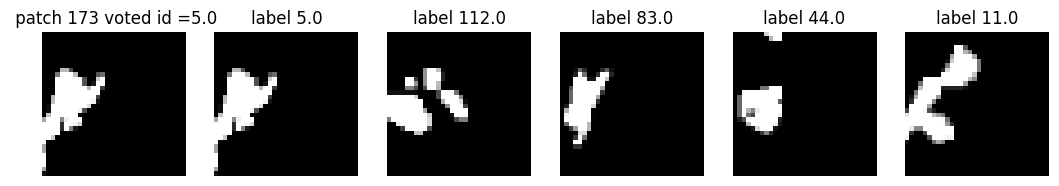

neighbors: [5.0, 79.0, 25.0, 88.0, 32.0] ; indices: [45062 48637 70886 20441 15284]


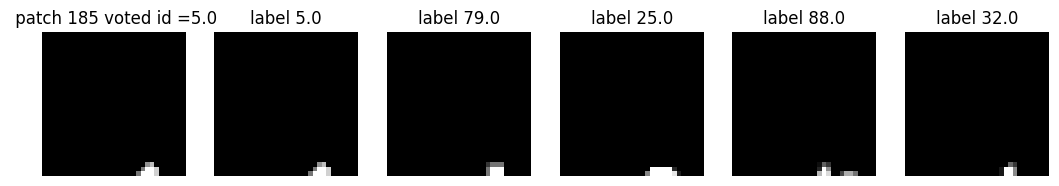

neighbors: [5.0, 26.0, 41.0, 88.0, 318.0] ; indices: [78653 44511 39487 74865  1637]


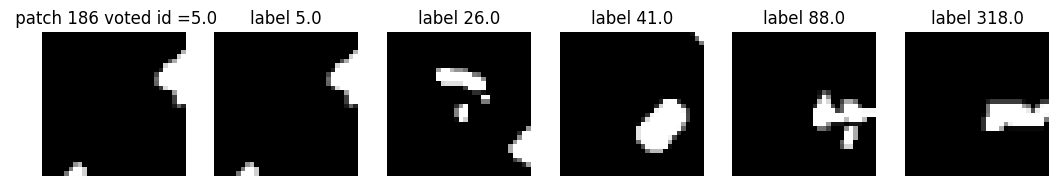

neighbors: [5.0, 79.0, 215.0, 228.0, 293.0] ; indices: [34769 53413 72342 27769 88503]


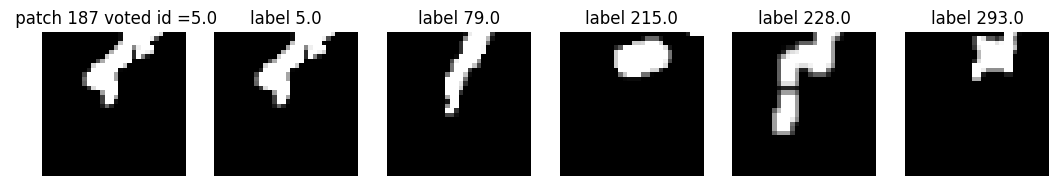

neighbors: [5.0, 6.0, 321.0, 100.0, 96.0] ; indices: [ 2492 81974 81511 85824 40796]


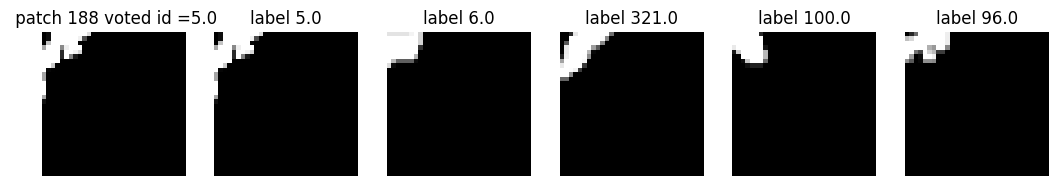

neighbors: [5.0, 309.0, 54.0, 47.0, 159.0] ; indices: [48247 85620  2048 41661 22241]


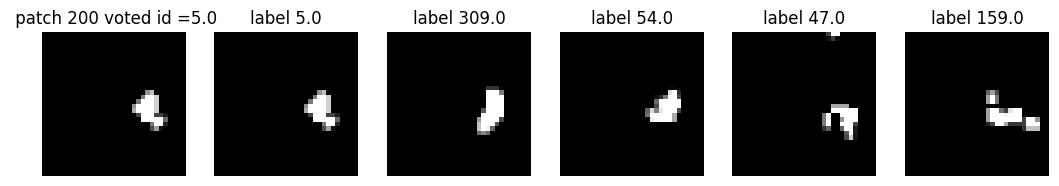

neighbors: [5.0, 68.0, 294.0, 183.0, 56.0] ; indices: [20194 61147 77634 63705 20979]


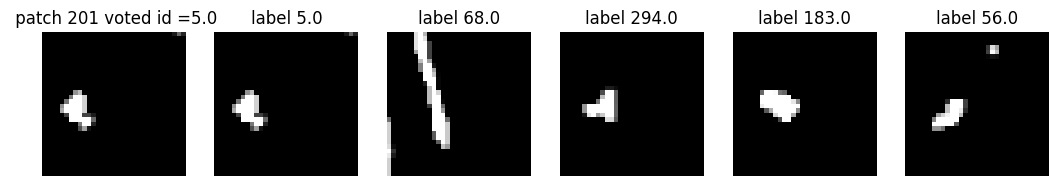

neighbors: [169.0, 20.0, 196.0, 315.0, 182.0] ; indices: [56196 56198 56195 56193 56197]


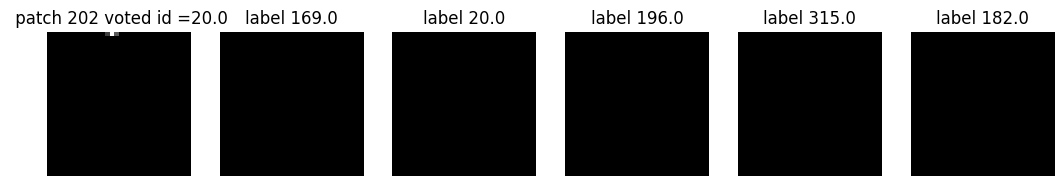

neighbors: [5.0, 46.0, 147.0, 87.0, 181.0] ; indices: [26502 34762  8791 49525  3542]


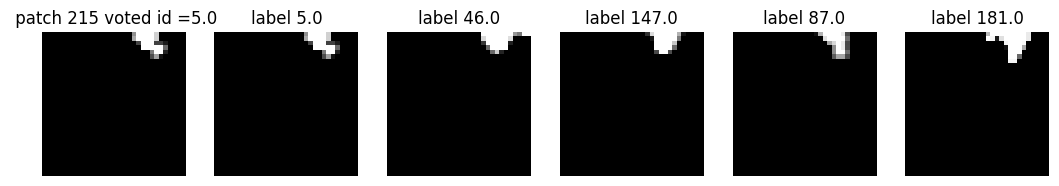

neighbors: [5.0, 87.0, 32.0, 55.0, 25.0] ; indices: [14449 56654 30610 22924 51655]


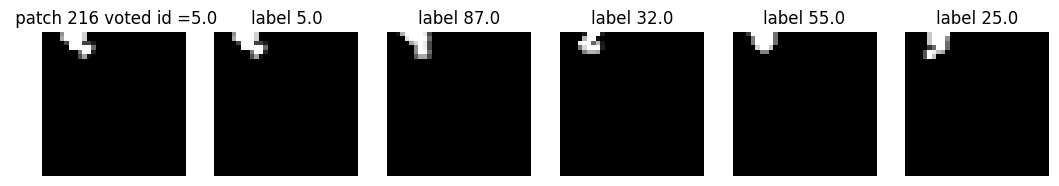

In [ ]:
display_solo_votes(list(dataset_dict.values())[8],reshaped_data,dataset_dict)

# 3. Evaluate identification

In [ ]:
data,dataset_dict=get_data(nu=True,images_too=True)
print("\nshape of dataset : {} ; shape of each sample : {}".format(data.shape,data[0].shape))
reshaped_data=reshape_data(data,nu=True)
print("\nshape of dataset : {} ; shape of each patch dataset : {}".format(reshaped_data.shape,reshaped_data[0].shape))

305/306
shape of dataset : (18235, 1049) ; shape of each sample : (1049,)
(18235, 1049)

shape of dataset : (18235, 1049) ; shape of each patch dataset : (1049,)


In [ ]:
KnnClassifier,_ = patch_solo_knns(reshaped_data)

len(train)=18235. ; len(test)=100
accuracy : 18.0


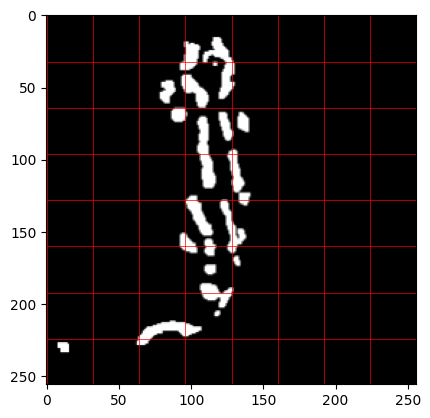

/content/drive/MyDrive/boleil_annotated/best_pattern_spot/004.png


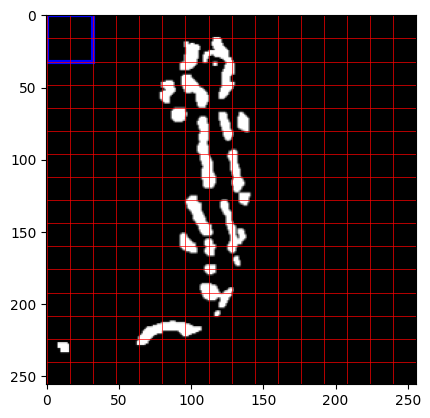

In [ ]:
sample_image=list(dataset_dict.values())[6]
plot_blocks(sample_image)
non_zero_idx=non_zero_patchs_idx(sample_image)
print(list(dataset_dict.keys())[6])
plot_blocks(sample_image,32,16)

#obscure= sample_image.copy()
### [ de haut en bas, de gauche a droite]
#obscure[64:128,190:220]=0
#obscure[220:280,195:220]=0
#obscure[0:45,195:220]=0

#plt.imshow(obscure,cmap="gray")
#plt.show()

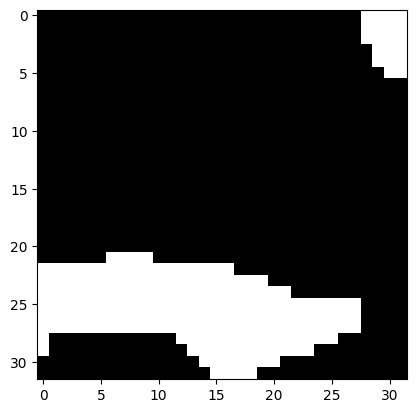

In [ ]:
sample_patches=get_non_zero_patchs(sample_image,32,16)
plt.imshow(sample_patches[59],cmap="gray")
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_blocks_idx(img, patch_size=32, stride=16, idx=-1):
    """
    Plot the image with red vertical and horizontal lines to visualize patch separation.
    In the case of a stride, a blue rectangle shows the size of the patch.
    If idx is provided, the idx-th non-zero patch will be highlighted in pink.
    """
    img = cv2.resize(img, (256, 256))
    fig, ax = plt.subplots()

    ax.imshow(img, cmap='gray')

    grid_color = 'red'
    grid_linewidth = 0.5
    patch_color = 'blue'
    patch_linewidth = 3
    highlight_color = 'pink'

    if stride == 0:
        for i in range(8):
            ax.axvline(i * 32, color=grid_color, linewidth=grid_linewidth)

        for i in range(8):
            ax.axhline(i * 32, color=grid_color, linewidth=grid_linewidth)
    else:
        num_patches_vertical = img.shape[0] // stride
        num_patches_horizontal = img.shape[1] // stride

        for i in range(num_patches_vertical):
            ax.axhline(i * stride, color=grid_color, linewidth=grid_linewidth)

        for i in range(num_patches_horizontal):
            ax.axvline(i * stride, color=grid_color, linewidth=grid_linewidth)
        rect = patches.Rectangle((0, 0), patch_size, patch_size, linewidth=patch_linewidth,
                                 edgecolor=patch_color, facecolor='none')
        ax.add_patch(rect)

    if idx >= 0:
        non_zero_patches = []
        for y in range(0, img.shape[0] - patch_size + 1, patch_size):
            for x in range(0, img.shape[1] - patch_size + 1, patch_size):
                patch = img[y:y + patch_size, x:x + patch_size]
                if np.sum(patch) > 0:
                    non_zero_patches.append(patch)

        if idx < len(non_zero_patches):
            non_zero_patch = non_zero_patches[idx]
            min_y, min_x = np.min(np.argwhere(non_zero_patch > 0), axis=0)
            max_y, max_x = np.max(np.argwhere(non_zero_patch > 0), axis=0)
            rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y,
                                     fill=False, edgecolor=highlight_color, linewidth=patch_linewidth)
            ax.add_patch(rect)

    ax.set_aspect('equal')
    plt.show()


# New section

In [ ]:
sample_image= list(dataset_dict.values())[27]
altered_1= sample_image.copy()
altered_1[64:128,190:220]=0
altered_2= sample_image.copy()
altered_2[64:128,190:220]=0
altered_2[220:280,195:220]=0
altered_3= sample_image.copy()
altered_3[64:128,190:220]=0
altered_3[220:280,195:220]=0
altered_3[0:45,195:220]=0

altered_4= sample_image.copy()
altered_4[64:128,190:220]=0

In [ ]:
v_,SAMPLES=solo_knn_results(  altered_3,reshaped_data,return_df=True)

len(train)=18235. ; len(test)=100
accuracy : 19.0
solo KNN vote 17/18

,votes,indices,neighbours,dist
0,32.0,"[10489, 15854, 477, 2259, 2245]","[32.0, 153.0, 228.0, 144.0, 31.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
1,32.0,"[10489, 15854, 477, 2259, 2245]","[32.0, 153.0, 228.0, 144.0, 31.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
2,32.0,"[10489, 15854, 477, 2259, 2245]","[32.0, 153.0, 228.0, 144.0, 31.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
3,32.0,"[10489, 15854, 477, 2259, 2245]","[32.0, 153.0, 228.0, 144.0, 31.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
4,32.0,"[10489, 15854, 477, 2259, 2245]","[32.0, 153.0, 228.0, 144.0, 31.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
5,24.0,"[18152, 17981, 1716, 6154, 7395]","[24.0, 233.0, 141.0, 30.0, 110.0]","[0.0, 0.018147689598875832, 0.0470947291645475..."
6,24.0,"[8652, 823, 12654, 2052, 18143]","[24.0, 2.0, 43.0, 116.0, 74.0]","[0.0, 0.2475134507728427, 0.282608474903926, 0..."
7,32.0,"[10489, 15854, 477, 2259, 2245]","[32.0, 153.0, 228.0, 144.0, 31.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
8,32.0,"[10489, 15854, 477, 2259, 2245]","[32.0, 153.0, 228.0, 144.0, 31.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
9,32.0,"[10489, 15854, 477, 2259, 2245]","[32.0, 153.0, 228.0, 144.0, 31.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"


,votes,frequency
0,32.0,13
1,24.0,4
2,266.0,1


In [ ]:
v_,SAMPLES=solo_knn_results(  altered_2,reshaped_data,return_df=True)

len(train)=18235. ; len(test)=100
accuracy : 24.0
solo KNN vote 17/18

,votes,indices,neighbours,dist
0,203.0,"[9314, 4521, 5710, 5274, 16958]","[203.0, 70.0, 203.0, 22.0, 100.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
1,203.0,"[9314, 4521, 5710, 5274, 16958]","[203.0, 70.0, 203.0, 22.0, 100.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
2,203.0,"[9314, 4521, 5710, 5274, 16958]","[203.0, 70.0, 203.0, 22.0, 100.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
3,203.0,"[9314, 4521, 5710, 5274, 16958]","[203.0, 70.0, 203.0, 22.0, 100.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
4,203.0,"[9314, 4521, 5710, 5274, 16958]","[203.0, 70.0, 203.0, 22.0, 100.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
5,24.0,"[12828, 10449, 8442, 2558, 2071]","[24.0, 233.0, 141.0, 30.0, 110.0]","[0.0, 0.01814768959886526, 0.04709472916455026..."
6,24.0,"[9809, 17375, 11071, 1020, 6651]","[24.0, 2.0, 43.0, 116.0, 74.0]","[0.0, 0.24751345077240727, 0.2826084749038837,..."
7,203.0,"[9314, 4521, 5710, 5274, 16958]","[203.0, 70.0, 203.0, 22.0, 100.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
8,203.0,"[9314, 4521, 5710, 5274, 16958]","[203.0, 70.0, 203.0, 22.0, 100.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
9,203.0,"[9314, 4521, 5710, 5274, 16958]","[203.0, 70.0, 203.0, 22.0, 100.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"


,votes,frequency
0,203.0,13
1,24.0,4
2,266.0,1


In [ ]:
v_,SAMPLES=solo_knn_results(  altered_1,reshaped_data,return_df=True)

len(train)=18235. ; len(test)=100
accuracy : 19.0
solo KNN vote 17/18

,votes,indices,neighbours,dist
0,99.0,"[16313, 3700, 16966, 12755, 5394]","[99.0, 170.0, 2.0, 246.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
1,99.0,"[16313, 3700, 16966, 12755, 5394]","[99.0, 170.0, 2.0, 246.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
2,99.0,"[16313, 3700, 16966, 12755, 5394]","[99.0, 170.0, 2.0, 246.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
3,99.0,"[16313, 3700, 16966, 12755, 5394]","[99.0, 170.0, 2.0, 246.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
4,99.0,"[16313, 3700, 16966, 12755, 5394]","[99.0, 170.0, 2.0, 246.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
5,24.0,"[4731, 4909, 14178, 12310, 1704]","[24.0, 233.0, 141.0, 30.0, 110.0]","[0.0, 0.01814768959881227, 0.04709472916460547..."
6,24.0,"[12324, 12518, 13245, 11065, 3509]","[24.0, 2.0, 43.0, 116.0, 74.0]","[0.0, 0.24751345077207274, 0.2826084749040814,..."
7,99.0,"[16313, 3700, 16966, 12755, 5394]","[99.0, 170.0, 2.0, 246.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
8,99.0,"[16313, 3700, 16966, 12755, 5394]","[99.0, 170.0, 2.0, 246.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
9,99.0,"[16313, 3700, 16966, 12755, 5394]","[99.0, 170.0, 2.0, 246.0, 5.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"


,votes,frequency
0,99.0,13
1,24.0,4
2,266.0,1


In [ ]:
v_,SAMPLES=solo_knn_results(list(dataset_dict.values())[8],reshaped_data,return_df=True)

len(train)=18235. ; len(test)=100
accuracy : 23.0
solo KNN vote 13/14

,votes,indices,neighbours,dist
0,233.0,"[2105, 8420, 6109, 559, 16771]","[233.0, 14.0, 89.0, 81.0, 64.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
1,233.0,"[2105, 8420, 6109, 559, 16771]","[233.0, 14.0, 89.0, 81.0, 64.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
2,233.0,"[2105, 8420, 6109, 559, 16771]","[233.0, 14.0, 89.0, 81.0, 64.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
3,233.0,"[2105, 8420, 6109, 559, 16771]","[233.0, 14.0, 89.0, 81.0, 64.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
4,233.0,"[2105, 8420, 6109, 559, 16771]","[233.0, 14.0, 89.0, 81.0, 64.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
5,5.0,"[5874, 6674, 4852, 12903, 8970]","[5.0, 218.0, 39.0, 259.0, 93.0]","[0.0, 0.39238772823673745, 0.4339439156790315,..."
6,233.0,"[2105, 8420, 6109, 559, 16771]","[233.0, 14.0, 89.0, 81.0, 64.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
7,233.0,"[2105, 8420, 6109, 559, 16771]","[233.0, 14.0, 89.0, 81.0, 64.0]","[0.0, 0.0, 0.0, 0.0, 0.0]"
8,5.0,"[1013, 10710, 16283, 17333, 10559]","[5.0, 150.0, 93.0, 88.0, 106.0]","[0.0, 1.169948727688365, 1.2463716846293893, 1..."
9,5.0,"[10971, 10220, 11055, 2304, 2343]","[5.0, 57.0, 70.0, 296.0, 11.0]","[0.0, 2.0281513805421065, 2.0617097952381096, ..."


,votes,frequency
0,233.0,9
1,5.0,5


In [ ]:
def image_identification(sample_image,id=1, KnnClassifier=None, dataset=None,top_five=False):
  """
    This function return the predicted identity for a sample_image by KnnClassifier
    if KnnClassifier=None, a KNN model is trained on dataset !=None
    returns: (int) predicted identity
  """
  if type(KnnClassifier) == "NoneType":
    if dataset != "NoneType":
      KnnClassifier,_= patch_solo_knns(dataset)
    else:
      print("dataset required to train KnnClassifier")
  found=0
  patch_votes,_,_ = get_solo_knn_votes(sample_image,KnnClassifier,nu=True)
  df=pd.DataFrame(np.asarray(patch_votes).reshape(len(patch_votes),),columns=["votes"])
  non_zero_idx=non_zero_patchs_idx(sample_image)
  extracted_values = df['votes'] #df.iloc[non_zero_idx]['votes']
  value_counts = extracted_values.value_counts()
  frequency_df = pd.DataFrame({'votes': value_counts.index, 'frequency': value_counts.values})
  vote_with_highest_freq = frequency_df.loc[frequency_df['frequency'].idxmax(), 'votes']

   #display(frequency_df)

  if top_five:
   # top_votes = frequency_df.head(5)['votes'].tolist()
     #top_votes = frequency_df.head(5)[['votes', 'frequency']].apply(tuple, axis=1).tolist()
     top_votes = frequency_df[['votes', 'frequency']].apply(tuple, axis=1).tolist()

  if id in frequency_df['votes']:
    found=1
  return top_votes#,found

  return vote_with_highest_freq


def get_scenario_paths(dataset_dict,closed_set=True):
  """
     In the case of closed set evaluation this function returns the paths of all images concerned i.e with occurrence > 1
     In the case of open set evaluation this function returns the paths of all images concerned i.e with occurrence = 1
  """
  dataset_dict_helper=map_path_id(dataset_dict.keys())
  identities = list(dataset_dict_helper.keys())
  occurrences = [len(paths) for paths in dataset_dict_helper.values()]
  path_lists = list(dataset_dict_helper.values())

  # Create a DataFrame
  data = {"identity": identities, "occurrence": occurrences, "path": path_lists}
  df = pd.DataFrame(data)
  if closed_set:
    filtered_df = df[df['occurrence'] > 1]
  else:
   filtered_df = df[df['occurrence']  < 2]

  concatenated_paths = []
  for paths in filtered_df['path']:
      concatenated_paths.extend(paths)
  return concatenated_paths

def plot_top_five(sample_image, KnnClassifier,datadict):

  to_plot=[]
  dataset_dict_helper=map_path_id(dataset_dict.keys())
  ids= image_identification(sample_image,KnnClassifier=KnnClassifier, top_five=True)

  for id in ids:
    to_plot.extend(dataset_dict_helper[id[0]])

  num_to_plot = len(to_plot)

    # Create a multi-line plot

    # Plot the sample_image in the first line
  plt.figure(figsize=(2,2))
  plt.imshow(sample_image,cmap="gray")
  plt.title('Sample Image')
  plt.axis('off')

  fig, axes = plt.subplots(nrows=1, ncols=num_to_plot , figsize=(20, 20))

    # Plot the images from to_plot in the second line
  for i, img_path in enumerate(to_plot):
      img = Image.open(img_path).convert("L")
      axes[ i].imshow(img,cmap="gray")
      axes[i].set_title(f' {img_path.split("/")[-1]}')
      axes[i].axis('off')

    # Adjust layout and display the plot
  plt.tight_layout()
  plt.show()


solo KNN vote 64/65

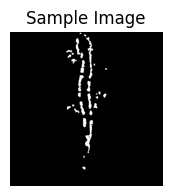

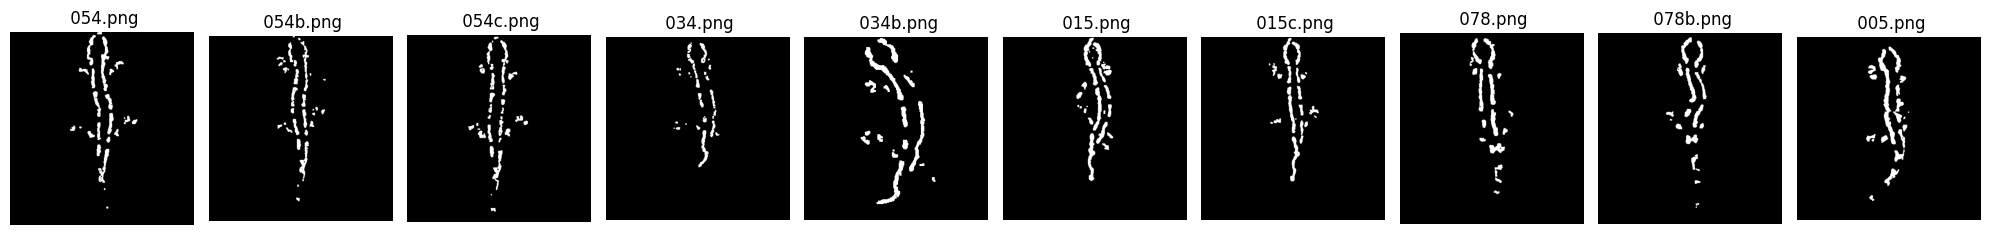

In [ ]:
plot_top_five(sample_image, KnnClassifier,dataset_dict)

305/306(18235, 1049)
len(train)=18235. ; len(test)=100
accuracy : 20.0
solo KNN vote 15/16

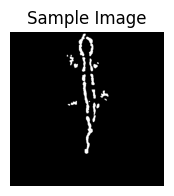

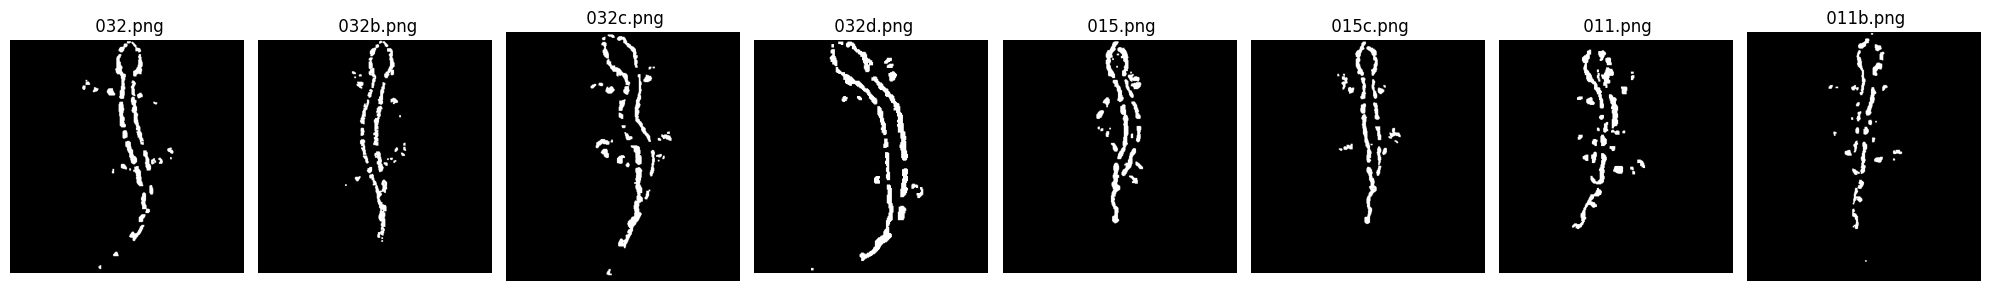

In [ ]:
path="/content/drive/MyDrive/boleil_annotated/best_pattern_spot/015c.png"
image= np.array(Image.open(path).convert("L"))
data,dataset_dict=get_data(nu=True,skip_img=None,images_too=True)
reshaped_data=reshape_data(data,nu=True)
KnnClassifier,_ = patch_solo_knns(reshaped_data)
plot_top_five(image, KnnClassifier,dataset_dict)

In [ ]:
image_identification(sample_image,KnnClassifier)

In [ ]:
def run_identification(dataset_dict):
  """
    This function is used to run the evaluation.
    For a closed set (resp open set) we group the paths of images > 1 occurrence (resp = 1 occurrence)
    For each of those images, we train a KnnClassifier on all other images and predict its identity
  """
  non_unique_identities= get_scenario_paths(dataset_dict, closed_set= True)
  hits={}
  large_hits=0
  for path in non_unique_identities :

    data=get_data(nu=True,skip_img=path)
    data=reshape_data(data,nu=True)
    KnnClassifier,_= patch_solo_knns(data,)
    image= dataset_dict[path]
    filename = path.split("/")[-1]
    true_id= int( re.sub(r'\D', '', filename))
    top_five,large_hit = image_identification(image,true_id,KnnClassifier,top_five=True)
    top_five_ids=  [pair[0] for pair in top_five]

    print(" image of ID {} predicted as ID {}; 5 ranks: {}".format(true_id,top_five[0],top_five))
    if true_id in top_five_ids:
      if true_id in hits.keys():
        hits[true_id]+=1
      else :
        hits[true_id]= 1
    large_hits+=large_hit
  print("HITS = {} ; TOTAL= {}".format(len(list(hits.keys())), len(non_unique_identities)))
  print("LARGE_HITS = {} ; TOTAL= {}".format(large_hits, len(non_unique_identities)))


In [ ]:
run_identification(dataset_dict)

305/306(12134, 281)
len(train)=12134. ; len(test)=100
accuracy : 19.0
solo KNN vote 56/57 image of ID 2 predicted as ID (39.0, 50.0); 5 ranks: [(39.0, 50.0), (29.0, 2.0), (10.0, 1.0), (81.0, 1.0), (40.0, 1.0), (11.0, 1.0), (137.0, 1.0)]
305/306(12132, 281)
len(train)=12132. ; len(test)=100
accuracy : 19.0
solo KNN vote 60/61 image of ID 2 predicted as ID (163.0, 52.0); 5 ranks: [(163.0, 52.0), (21.0, 2.0), (2.0, 2.0), (3.0, 1.0), (5.0, 1.0), (45.0, 1.0), (22.0, 1.0), (7.0, 1.0)]
305/306(12123, 281)
len(train)=12123. ; len(test)=100
accuracy : 22.0
solo KNN vote 77/78 image of ID 2 predicted as ID (7.0, 73.0); 5 ranks: [(7.0, 73.0), (32.0, 1.0), (21.0, 1.0), (4.0, 1.0), (19.0, 1.0), (6.0, 1.0)]
305/306(12130, 281)
len(train)=12130. ; len(test)=100
accuracy : 21.0
solo KNN vote 60/61 image of ID 3 predicted as ID (27.0, 53.0); 5 ranks: [(27.0, 53.0), (21.0, 1.0), (146.0, 1.0), (25.0, 1.0), (132.0, 1.0), (30.0, 1.0), (16.0, 1.0), (11.0, 1.0), (54.0, 1.0)]
305/306(12125, 281)
len(train)=12

In [ ]:
run_identification(dataset_dict)

305/306(12134, 281)
len(train)=12134. ; len(test)=100
accuracy : 28.0
solo KNN vote 56/57 image of ID 2 predicted as ID (27.0, 50.0); 5 ranks: [(27.0, 50.0), (29.0, 2.0), (10.0, 1.0), (81.0, 1.0), (40.0, 1.0), (11.0, 1.0), (137.0, 1.0)]
305/306(12132, 281)
len(train)=12132. ; len(test)=100
accuracy : 27.0
solo KNN vote 60/61 image of ID 2 predicted as ID (141.0, 52.0); 5 ranks: [(141.0, 52.0), (21.0, 2.0), (2.0, 2.0), (3.0, 1.0), (5.0, 1.0), (45.0, 1.0), (22.0, 1.0), (7.0, 1.0)]
305/306(12123, 281)
len(train)=12123. ; len(test)=100
accuracy : 21.0
solo KNN vote 77/78 image of ID 2 predicted as ID (70.0, 73.0); 5 ranks: [(70.0, 73.0), (32.0, 1.0), (21.0, 1.0), (4.0, 1.0), (19.0, 1.0), (6.0, 1.0)]
305/306(12130, 281)
len(train)=12130. ; len(test)=100
accuracy : 21.0
solo KNN vote 60/61 image of ID 3 predicted as ID (4.0, 53.0); 5 ranks: [(4.0, 53.0), (21.0, 1.0), (146.0, 1.0), (25.0, 1.0), (132.0, 1.0), (30.0, 1.0), (16.0, 1.0), (11.0, 1.0), (54.0, 1.0)]
305/306(12125, 281)
len(train)=12

In [ ]:
path_=""
test_image=np.array(Image.open())
train_dataset=get_data(nu=True,skip_img=path_)
train_dataset=reshape_data(train_dataset,nu=True)

v_,SAMPLES=solo_knn_results(test_image,train_dataset,return_df=True)